https://arxiv.org/abs/2007.14044

In [136]:
!pip3 install qiskit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [137]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split

qs = qiskit.Aer.get_backend('qasm_simulator')

# Useful functions

## Preprocessing functions

In [138]:
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

def rescaleFeature(x, alpha, q):
    return (1-alpha/2) * (np.pi/q) * standardise(x)

## Circuit functions

In [139]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

# Quantum Classifier Class

In [142]:
def logSoftmax(label, job_results, bitstrings, nshots) :
    if label in job_results :
        e = np.exp(job_results[label] / nshots)
    else :
        e = 1
        
    s = 0
    for bitstring in bitstrings :
        if bitstring in job_results :
            s += np.exp(job_results[bitstring] / nshots)
        else :
            s += 1 
            
    return -np.log(e / s)


In [144]:
class QuantumClassifier:

    def __init__(self, circuit_builder, bitstrings, theta_size, loss_function = logSoftmax, optimizer_method = "COBYLA"):
        self.circuit_builder = circuit_builder
        self.bitstrings = bitstrings
        self.theta_size = theta_size
        self.loss_function = loss_function
        self.optimizer_method = optimizer_method
        self.theta = None
        self.nshots = 100
        
    
    # Training functions
    def executeJob(self, circuit):
        job = qiskit.execute(circuit, shots=self.nshots, backend=qs)
        job_results = job.result().get_counts()
        return job_results

    def runCircuit(self, theta, X, y):
        omega = X
        label = y

        circuit = self.circuit_builder(theta, omega)
        job_results = self.executeJob(circuit)
        return self.loss_function(label, job_results, self.bitstrings, self.nshots)
        
        
    def lossBatch(self, theta, X, y):
    
        total_loss = 0

        batch = list(zip(X, y))

        for X_el, y_el in zip(X, y) :
            total_loss += self.runCircuit(theta, X_el, y_el)

        total_loss /= len(y)
        return total_loss

        
    def fit(self, X, y, nshots=100, maxiter=20, theta=None):
        
        if theta is not None:
            self.theta = theta
            
        if self.theta is None:
            self.theta = np.random.uniform(0, 2 * np.pi, self.theta_size)
            
        self.nshots = nshots

        opt = sp.optimize.minimize(
            fun=lambda params : self.lossBatch(params, X, y),
            x0=self.theta,
            method=self.optimizer_method,
            options={'maxiter': maxiter}
        )
        
        self.theta = opt.x
        
        return opt
    
    # Testing functions
    def argmaxJobResults(self, job_results):
        max_label_value = None
        max_label = None
    
        for label in job_results :
            if label in self.bitstrings and (max_label_value is None or job_results[label] >= max_label_value) :
                max_label = label
                max_label_value = job_results[label]
        return max_label
    
    def predict(self, X, theta=None, nshots=100):
        
        if theta is not None:
            self.theta = theta
            
        self.nshots = nshots
        
        y_pred = []
        
        for omega in X :    
            circuit = self.circuit_builder(self.theta, omega)
            job_results = self.executeJob(circuit)
            y_pred.append(self.argmaxJobResults(job_results))

        return y_pred

    def compute_accuracy(self, y_pred, y) :
        correct = 0

        for y_pred_el, y_el in zip(y_pred, y) :
            if y_pred_el == y_el :
                correct += 1
        
        return correct / len(y)

# IRIS

## Construct dataset

### Preprocess

In [148]:
df = pd.read_csv("iris.data")
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [149]:
alpha = 0.1
q = 3

#q = 3 fixé dans le papier

attributes = df.columns[:-1]

for x in attributes:
    df[x] = rescaleFeature(df[x], alpha, q)

df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,Iris-setosa
1,-1.137116,-0.124313,-1.334348,-1.306199,Iris-setosa
2,-1.378201,0.336104,-1.390920,-1.306199,Iris-setosa
3,-1.498743,0.105896,-1.277776,-1.306199,Iris-setosa
4,-1.016574,1.256938,-1.334348,-1.306199,Iris-setosa
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,Iris-virginica
146,0.550477,-1.275354,0.702249,0.917304,Iris-virginica
147,0.791562,-0.124313,0.815393,1.048098,Iris-virginica
148,0.429934,0.796521,0.928537,1.440481,Iris-virginica


In [150]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10"
}

df = df.replace({"class": diconvert})
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,00
1,-1.137116,-0.124313,-1.334348,-1.306199,00
2,-1.378201,0.336104,-1.390920,-1.306199,00
3,-1.498743,0.105896,-1.277776,-1.306199,00
4,-1.016574,1.256938,-1.334348,-1.306199,00
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,10
146,0.550477,-1.275354,0.702249,0.917304,10
147,0.791562,-0.124313,0.815393,1.048098,10
148,0.429934,0.796521,0.928537,1.440481,10


In [151]:
X = df[attributes].values
y = df["class"].values

### Split

In [152]:
train_size = 90
test_size = 60

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [153]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    iris_circuit = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : iris_circuit.cz(0, 1)
        psiGate(iris_circuit, omega[(2*i) % 4], 0)
        psiGate(iris_circuit, omega[(2*i+1) % 4], 1)
        
        iris_circuit.cz(0, 1)
        
        psiGate(iris_circuit, theta[(2*i)], 0)
        psiGate(iris_circuit, theta[(2*i+1)], 1)
        
    qc.append(iris_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

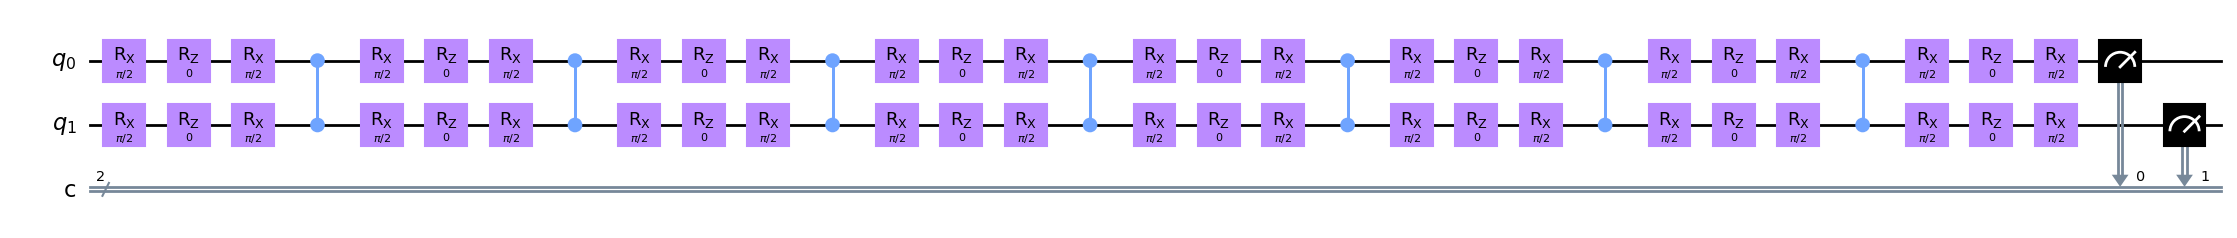

In [154]:
irisCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [155]:
iris_classifier = QuantumClassifier(irisCircuit, ['00', '01', '10'], 8)

In [156]:
opt = iris_classifier.fit(X_train, y_train, nshots=250, maxiter=20)
opt

     fun: 0.8159987028956617
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 20
  status: 2
 success: False
       x: array([1.95118107, 3.18542931, 1.46102746, 5.53089645, 5.76997268,
       3.39582352, 3.72009211, 1.38139698])

In [158]:
opt = iris_classifier.fit(X_train, y_train, nshots=500, maxiter=30)
opt

     fun: 0.8098305742888052
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 30
  status: 2
 success: False
       x: array([1.86862411, 3.35142535, 1.44258221, 5.48396387, 5.77509995,
       3.47687461, 3.68857966, 1.30568301])

In [159]:
opt = iris_classifier.fit(X_train, y_train, nshots=750, maxiter=70)
opt

     fun: 0.7997909199893892
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 70
  status: 2
 success: False
       x: array([1.86986259, 3.33783794, 1.34039523, 5.54000763, 5.78871995,
       3.75760179, 3.5278309 , 1.42077214])

## Compute results

In [161]:
y_pred = iris_classifier.predict(X_train)
iris_classifier.compute_accuracy(y_pred, y_train)

0.8444444444444444

In [163]:
y_pred = iris_classifier.predict(X_test)
iris_classifier.compute_accuracy(y_pred, y_test)

0.7333333333333333

# Gaussian XOR

### Generate dataset

In [186]:
import numpy as np
import math

In [187]:
def generate_gaussian_point(x, y, label) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return (pick_x, pick_y, label)

In [188]:
#dans le papier ils utilisent 1.5 et non pi / 2, a tester...

center1 = (-np.pi / 2, 0)
center2 = (np.pi / 2, 0)
center3 = (0, -np.pi / 2)
center4 = (0, np.pi / 2)

centers = [center1, center2, center3, center4]


In [189]:
points = []
for i in range(20) :
    points.append(generate_gaussian_point(*center1, 0))
    points.append(generate_gaussian_point(*center2, 0))
    points.append(generate_gaussian_point(*center3, 1))
    points.append(generate_gaussian_point(*center4, 1))


(-3.141592653589793, 3.141592653589793)

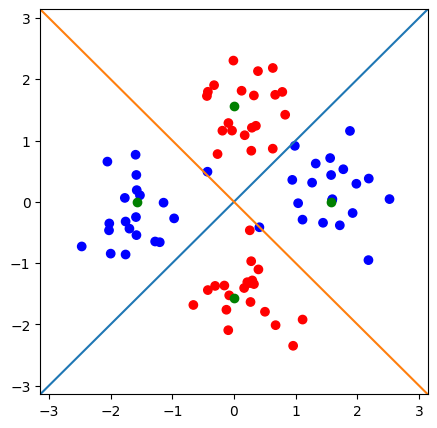

In [190]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

x,y,c = zip(*points)
c = ["blue" if el==0 else "red" for el in c]
plt.scatter(x, y, color=c)
x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [191]:
dataset = np.array(points)
dataset[:10]

array([[-0.97046929, -0.27084242,  0.        ],
       [ 2.5220301 ,  0.0439394 ,  0.        ],
       [ 0.39640948, -1.10371734,  1.        ],
       [-0.00912635,  2.30419312,  1.        ],
       [-2.46885861, -0.72920953,  0.        ],
       [ 1.44401293, -0.34258741,  0.        ],
       [-0.07727509, -1.52737762,  1.        ],
       [ 0.32290358,  1.73480845,  1.        ],
       [-2.02607264, -0.46556195,  0.        ],
       [ 1.26673741,  0.31189591,  0.        ]])

### Preprocess dataset

In [192]:
X = dataset[:, :2]
X[:10]

array([[-0.97046929, -0.27084242],
       [ 2.5220301 ,  0.0439394 ],
       [ 0.39640948, -1.10371734],
       [-0.00912635,  2.30419312],
       [-2.46885861, -0.72920953],
       [ 1.44401293, -0.34258741],
       [-0.07727509, -1.52737762],
       [ 0.32290358,  1.73480845],
       [-2.02607264, -0.46556195],
       [ 1.26673741,  0.31189591]])

In [193]:
diconvert = {
    0 : "00",
    1 : "10",
}

y = [diconvert[x] for x in dataset[:,2]]
y[:10]

['00', '00', '10', '10', '00', '00', '10', '10', '00', '00']

## Circuit

In [194]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    xor_circuit = qiskit.QuantumCircuit(2)
    
    psiGate(xor_circuit, omega[0], 0)
    psiGate(xor_circuit, omega[1], 1)
    
    for i in range(2):
        xor_circuit.cz(0, 1)
        psiGate(xor_circuit, theta[2*i], 0)
        psiGate(xor_circuit, theta[2*i+1], 1)
        
    
    qc.append(xor_circuit, range(2))
    qc.measure(range(2), range(2))
    return qc

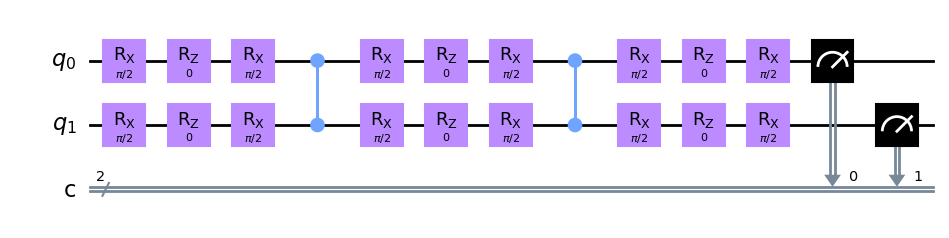

In [195]:
xorCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [196]:
xor_classifier = QuantumClassifier(xorCircuit, ['00', '10'], 4)

In [197]:
xor_opt = xor_classifier.fit(X, y, nshots=250, maxiter=80)
xor_opt

     fun: 0.506002120337554
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 53
  status: 1
 success: True
       x: array([ 1.84168138, -0.09479944,  1.95421372,  3.02751335])

## Compute results

In [198]:
y_pred = xor_classifier.predict(X)
xor_classifier.compute_accuracy(y_pred, y)

0.9875

In [199]:
lin = np.linspace(-np.pi, np.pi, num = 50)
X_test = np.array([[x, y] for x in lin for y in lin])

y_test = ["10" if abs(el[0]) < abs(el[1]) else "00" for el in X_test]

In [200]:
y_pred = xor_classifier.predict(X_test)

(-3.141592653589793, 3.141592653589793)

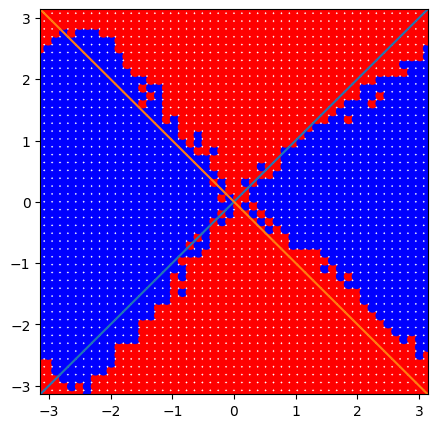

In [201]:
plt.rcParams['figure.figsize'] = [5,5]


c = ["blue" if el=="00" else "red" for el in y_pred]
plt.scatter(X_test[:, 0], X_test[:, 1], color=c)

x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [202]:
xor_classifier.compute_accuracy(y_pred, y_test)

0.8796

## Compare with GaussianNB

In [753]:
from sklearn.naive_bayes import GaussianNB

In [754]:
gaussianNb = GaussianNB()

X_train = dataset[:, :2]
y_train = dataset[:,2]

gaussianNb.fit(X_train, y_train)

y_test = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test]

score = gaussianNb.score(X_test, y_test)

In [755]:
score

0.916

# Skin segmentation

In [756]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3)
    psiGate(qc, omega[0], 0)
    psiGate(qc, omega[1], 1)
    psiGate(qc, omega[2], 2)
    
    qc.cz(0, 2)
    
    psiGate(qc, theta[0], 0)
    psiGate(qc, theta[1], 2)
    
    qc.cz(0, 1)
    
    psiGate(qc, theta[2], 0)
    psiGate(qc, theta[3], 1)
    
    qc.cz(1, 2)
    
    psiGate(qc, theta[4], 1)
    psiGate(qc, theta[5], 2)
    return qc

# Synthetic dataset with 4 classes

In [ ]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i)], 0)
        psiGate(qc, theta[(6*i+1)], 1)
        qc.cz(0, 1)
        psiGate(qc, omega[0], 0)
        psiGate(qc, omega[1], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+2)], 0)
        psiGate(qc, theta[(6*i+3)], 1)
        qc.cz(0, 1)
        psiGate(qc, theta[(6*i+4)], 0)
        psiGate(qc, theta[(6*i+5)], 1)
    return qc

# Run on IBM Quantum Computer

In [ ]:
TOKEN = ...

In [ ]:
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())

mapped_circuit = qiskit.transpile(circuit, backend=backend)
qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=1024)

IBMQAccountCredentialsInvalidToken: 'Invalid IBM Quantum Experience token found: "Ellipsis" of type <class \'ellipsis\'>.'

In [ ]:
# execute the circuit
job = backend.run(qobj)


In [ ]:
job.status()


In [ ]:
ID = job.job_id()

In [ ]:
job = backend.retrieve_job(ID)

In [ ]:
result = job.result()

In [ ]:
counts = result.get_counts()

In [ ]:
counts